In [8]:
!pip install pyspark

In [9]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
.master("local")\
.appName("ClusteringApp")\
.enableHiveSupport()\
.config('spark.ui.port', '4050')\
.getOrCreate()

In [10]:
path="/content/Grocery (1).csv"

In [12]:
#Reading  csv file
df = spark.read.csv(path,
                             inferSchema=True,
                             header=True)

In [13]:
df.show(7)
df.count()

+-------+------+-----+----+-------+------+----------------+----------+
|Channel|Region|Fresh|Milk|Grocery|Frozen|Detergents_Paper|Delicassen|
+-------+------+-----+----+-------+------+----------------+----------+
|      2|     3|12669|9656|   7561|   214|            2674|      1338|
|      2|     3| 7057|9810|   9568|  1762|            3293|      1776|
|      2|     3| 6353|8808|   7684|  2405|            3516|      7844|
|      1|     3|13265|1196|   4221|  6404|             507|      1788|
|      2|     3|22615|5410|   7198|  3915|            1777|      5185|
|      2|     3| 9413|8259|   5126|   666|            1795|      1451|
|      2|     3|12126|3199|   6975|   480|            3140|       545|
+-------+------+-----+----+-------+------+----------------+----------+
only showing top 7 rows



440

In [14]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+-------+------+-----+----+-------+------+----------------+----------+
|Channel|Region|Fresh|Milk|Grocery|Frozen|Detergents_Paper|Delicassen|
+-------+------+-----+----+-------+------+----------------+----------+
|      0|     0|    0|   0|      0|     0|               0|         0|
+-------+------+-----+----+-------+------+----------------+----------+



In [15]:
data_df=df.toPandas()

In [16]:
from pyspark.ml.feature import VectorAssembler
ClusteringColumns = ['Fresh', 'Milk', 'Grocery']

assembler=VectorAssembler(inputCols=ClusteringColumns, outputCol="features")
featureDf = assembler.transform(df)
featureDf.printSchema()
featureDf.show(10)

root
 |-- Channel: integer (nullable = true)
 |-- Region: integer (nullable = true)
 |-- Fresh: integer (nullable = true)
 |-- Milk: integer (nullable = true)
 |-- Grocery: integer (nullable = true)
 |-- Frozen: integer (nullable = true)
 |-- Detergents_Paper: integer (nullable = true)
 |-- Delicassen: integer (nullable = true)
 |-- features: vector (nullable = true)

+-------+------+-----+-----+-------+------+----------------+----------+--------------------+
|Channel|Region|Fresh| Milk|Grocery|Frozen|Detergents_Paper|Delicassen|            features|
+-------+------+-----+-----+-------+------+----------------+----------+--------------------+
|      2|     3|12669| 9656|   7561|   214|            2674|      1338|[12669.0,9656.0,7...|
|      2|     3| 7057| 9810|   9568|  1762|            3293|      1776|[7057.0,9810.0,95...|
|      2|     3| 6353| 8808|   7684|  2405|            3516|      7844|[6353.0,8808.0,76...|
|      1|     3|13265| 1196|   4221|  6404|             507|      1788|

In [18]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
cluster_count = [5]#[10,30,50,70,90]
wssse_values =[]
for i in range(2,8):
  bkmeans = BisectingKMeans().setK(i).setSeed(1).setFeaturesCol("features").setPredictionCol("prediction")
  Model = bkmeans.fit(featureDf) # Use featureDf directly

  # test the model with test data set
  predictDf = Model.transform(featureDf) # Use featureDf directly


  evaluator = ClusteringEvaluator()
  silhouette = evaluator.evaluate(predictDf)

  wssse_values.append(silhouette)
  print("clusters= "+str(i) +" Silhouette with squared euclidean distance: "+ str(silhouette))
  #for clusters in kmeansModel.clusterCenters():
    #print("cluster centres",clusters)

clusters= 2 Silhouette with squared euclidean distance: 0.6988637792815962
clusters= 3 Silhouette with squared euclidean distance: 0.5528919668349952
clusters= 4 Silhouette with squared euclidean distance: 0.6174460755315636
clusters= 5 Silhouette with squared euclidean distance: 0.45794907053471806
clusters= 6 Silhouette with squared euclidean distance: 0.47818859422125537
clusters= 7 Silhouette with squared euclidean distance: 0.5104609022736065


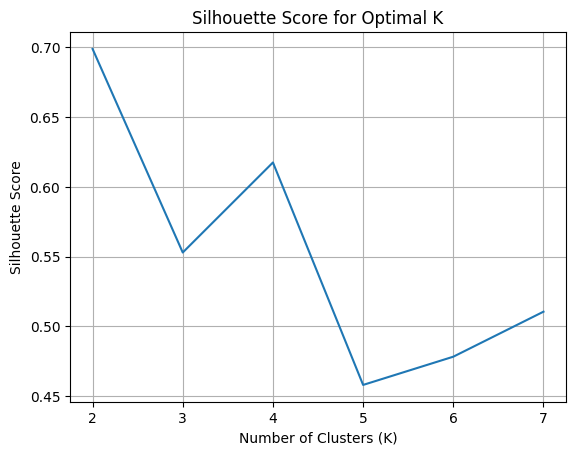

In [20]:
import matplotlib.pyplot as plt

# Plotting WSSSE values
plt.plot(range(2, 8), wssse_values)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.grid()
plt.show()

In [22]:
# test the model with test data set
predictDf = Model.transform(featureDf)
predictDf.show(10)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictDf)
print("Silhouette with squared euclidean distance = " + str(silhouette))

+-------+------+-----+-----+-------+------+----------------+----------+--------------------+----------+
|Channel|Region|Fresh| Milk|Grocery|Frozen|Detergents_Paper|Delicassen|            features|prediction|
+-------+------+-----+-----+-------+------+----------------+----------+--------------------+----------+
|      2|     3|12669| 9656|   7561|   214|            2674|      1338|[12669.0,9656.0,7...|         1|
|      2|     3| 7057| 9810|   9568|  1762|            3293|      1776|[7057.0,9810.0,95...|         0|
|      2|     3| 6353| 8808|   7684|  2405|            3516|      7844|[6353.0,8808.0,76...|         0|
|      1|     3|13265| 1196|   4221|  6404|             507|      1788|[13265.0,1196.0,4...|         1|
|      2|     3|22615| 5410|   7198|  3915|            1777|      5185|[22615.0,5410.0,7...|         4|
|      2|     3| 9413| 8259|   5126|   666|            1795|      1451|[9413.0,8259.0,51...|         0|
|      2|     3|12126| 3199|   6975|   480|            3140|    

In [23]:
predictDf.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  109|
|         6|    7|
|         3|   18|
|         5|   18|
|         4|   43|
|         2|   64|
|         0|  181|
+----------+-----+



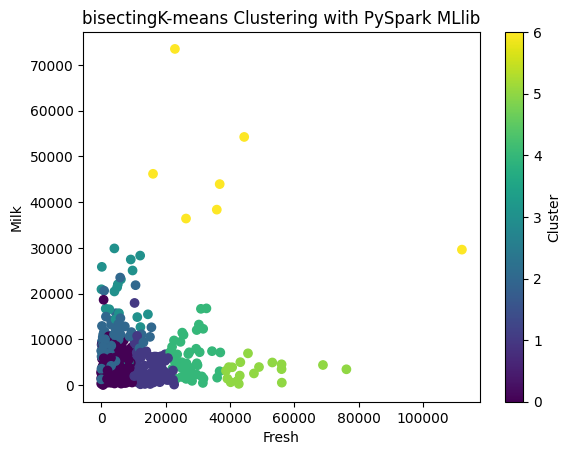

In [24]:
# Converting to Pandas DataFrame
clustered_data_pd = predictDf.toPandas()
# Visualizing the results
plt.scatter(clustered_data_pd["Fresh"], clustered_data_pd["Milk"], c=clustered_data_pd["prediction"], cmap='viridis')
plt.xlabel("Fresh")
plt.ylabel("Milk")
plt.title("bisectingK-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

In [25]:
import plotly.express as px

In [26]:
fig = px.scatter_3d(clustered_data_pd, x='Fresh', y='Milk', z='Grocery', color='prediction')
fig.show()

Comparison and Analysis between K-Means and Bisecting K-Means

 For Grocery Dataset
 Applying KMeans
 clusters= 2 Silhouette with squared euclidean distance: 0.6458135149211761
clusters= 3 Silhouette with squared euclidean distance: 0.6580959577405316
clusters= 4 Silhouette with squared euclidean distance: 0.5854556894072328
clusters= 5 Silhouette with squared euclidean distance: 0.5523590775631999
clusters= 6 Silhouette with squared euclidean distance: 0.5313625049075387
clusters= 7 Silhouette with squared euclidean distance: 0.43224285468732243

silhouette with squared euclidean distance = 0.43224285468732243

Applying Bisecting K Means
clusters= 2 Silhouette with squared euclidean distance: 0.6988637792815962
clusters= 3 Silhouette with squared euclidean distance: 0.5528919668349952
clusters= 4 Silhouette with squared euclidean distance: 0.6174460755315636
clusters= 5 Silhouette with squared euclidean distance: 0.45794907053471806
clusters= 6 Silhouette with squared euclidean distance: 0.47818859422125537
clusters= 7 Silhouette with squared euclidean distance: 0.5104609022736065

Silhouette with squared euclidean distance = 0.5104609022736065